# Install and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gc
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pandas as pd
#from tabulate import tabulate
from IPython.display import display

# Reading the data

In [2]:
input_file_path = "/kaggle/input/tow-ids/"

In [3]:
# Carregue seus dados (substitua 'X.npy' e 'y.npy' pelo caminho dos seus arquivos)
y = pd.read_csv(f"{input_file_path}/y_test_TOW_IDS_dataset_one_class_Wsize_44_Cols_116_Wslide_1_MC_False_sumX_False.csv")
y = y['Class'].values

X = np.load(f"{input_file_path}/X_test_TOW_IDS_dataset_one_class_Wsize_44_Cols_116_Wslide_1_MC_False_sumX_False-001.npz")
X = X['arr_0']

In [4]:
X.shape, y.shape

((791566, 44, 116), (791566,))

# Evaluation function

In [5]:
def avaliacao_modelo(file_path, val):
    model_index = int(val)
    
    # Carrega o modelo
    model = load_model(f'{file_path}/model_{val}.keras')
    
    # Avalia loss e accuracy
    loss, accuracy = model.evaluate(X, y, verbose=0)
    
    # Gera as predições com um batch_size reduzido
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calcula precision e recall
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    
    # Calcula a curva ROC e a AUC
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Salva as métricas em um CSV (um por modelo)
    df_metrics = pd.DataFrame([{
        'model': model_index,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': roc_auc
    }])
    df_metrics.to_csv(f'metrics_model_{model_index}.csv', index=False)
    
    # Salva os dados da curva ROC para plotagem futura
    df_roc = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
    df_roc.to_csv(f'roc_model_{model_index}.csv', index=False)
    
    print(f"Modelo {model_index} processado e resultados salvos.")
    
    # Libera a memória
    del model, y_pred, y_pred_prob, fpr, tpr
    K.clear_session()
    gc.collect()

# Performing the evaluation for each fold

In [6]:
model_folder_path = "/kaggle/input/5-fold_tow_ids_one_class_w44_116/keras/default/1/"

In [7]:
avaliacao_modelo(model_folder_path, 0)

24737/24737 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Modelo 0 processado e resultados salvos.


In [8]:
avaliacao_modelo(model_folder_path, 1)

24737/24737 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
Modelo 1 processado e resultados salvos.


In [9]:
avaliacao_modelo(model_folder_path, 2)

24737/24737 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
Modelo 2 processado e resultados salvos.


In [10]:
avaliacao_modelo(model_folder_path, 3)

24737/24737 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
Modelo 3 processado e resultados salvos.


In [11]:
avaliacao_modelo(model_folder_path, 4)

24737/24737 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Modelo 4 processado e resultados salvos.


# Plotting and printing metrics

Métricas consolidadas salvas em 'metricas_modelos_final.csv'.


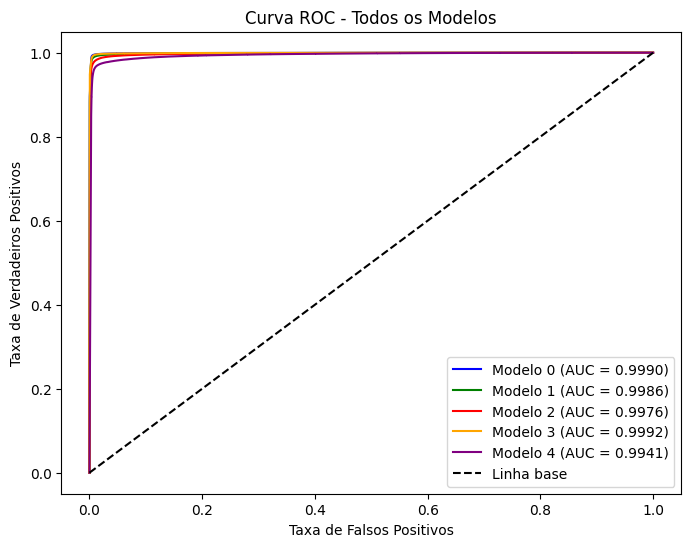

In [12]:
# Agrega os arquivos de métricas individuais
metrics_files = glob.glob('metrics_model_*.csv')
df_list = [pd.read_csv(f) for f in metrics_files]
df_metrics = pd.concat(df_list, ignore_index=True)
df_metrics.to_csv('metricas_modelos_final.csv', index=False)
print("Métricas consolidadas salvas em 'metricas_modelos_final.csv'.")

# Cria o gráfico para as curvas ROC
plt.figure(figsize=(8, 6))
cores = ['blue', 'green', 'red', 'orange', 'purple']

for i in range(5):
    roc_file = f'roc_model_{i}.csv'
    try:
        df_roc = pd.read_csv(roc_file)
        # Obtem o valor de AUC do DataFrame consolidado
        auc_val = df_metrics.loc[df_metrics['model'] == i, 'auc'].values[0]
        plt.plot(df_roc['fpr'], df_roc['tpr'], color=cores[i % len(cores)],
                 label=f'Modelo {i} (AUC = {auc_val:.4f})')
    except FileNotFoundError:
        print(f"Arquivo {roc_file} não encontrado.")

# Plota a linha base e configurações finais
plt.plot([0, 1], [0, 1], 'k--', label='Linha base')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Todos os Modelos')
plt.legend(loc='lower right')
plt.show()

In [13]:
# Lê o CSV consolidado
df_metrics = pd.read_csv('metricas_modelos_final.csv')
display(df_metrics)


,model,loss,accuracy,precision,recall,auc
0,0,0.060691,0.993788,0.995091,0.990768,0.998992
1,1,0.065739,0.990166,0.994699,0.982885,0.998550
2,2,0.132862,0.972829,0.948644,0.991936,0.997614
3,3,0.058732,0.993144,0.993039,0.991365,0.999165
4,4,0.176493,0.976285,0.990700,0.955058,0.994053
